# XGBoost Model (With Market Cap Restriction)
本模型採用 XGBoostClassifier, 並考慮市值>200億的股票

In [195]:
import numpy as np
import pandas as pd
import yfinance as yf
import quantstats as qs
import matplotlib.pyplot as plt
import xgboost

from sklearn.preprocessing import *
from sklearn.model_selection import cross_val_score
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK

from src.data_loading import *
from src.data_processing import *
from src.backtesting import *

pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']

## Load Price Data

In [214]:
price = load_price_data()
price_0812 = load_price_data(path='./data/price_daily_0812.csv')
price_0823 =load_price_data(path='./data/price_daily_0823.csv')

/Users/stuartlu/Documents/國泰人壽/ML 選股/src/data_loading.py:26: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  price = pd.read_csv(path, encoding='cp950')


In [215]:
price = combine_df(price, price_0812, price_0823)
price = calculate_daily_return(price)
price = remove_special_stocks(price)
price

Open      High       Low     Close  Volume  \
證券代碼     年月日                                                          
1101 台泥  2015-01-05   20.3688   20.3688   20.0872   20.1810    2842   
         2015-01-06   19.9464   19.9933   19.7586   19.8290    7654   
         2015-01-07   19.8290   19.9698   19.6413   19.7586    8719   
         2015-01-08   19.8290   20.0168   19.7586   19.8290    8697   
         2015-01-09   19.8525   19.9933   19.6178   19.6178   10494   
...                       ...       ...       ...       ...     ...   
9958 世紀鋼 2024-08-19  204.6010  209.0380  202.6290  203.1220    3631   
         2024-08-20  205.5870  217.9120  203.1220  209.0380   11230   
         2024-08-21  208.5450  213.4750  205.0940  206.0800    6727   
         2024-08-22  209.0000  216.0000  208.5000  211.5000    6669   
         2024-08-23  214.0000  214.5000  205.5000  212.5000    7583   

                     QuoteVolume  MarketCap  YSTD Close  TMR Close  \
證券代碼     年月日                                                         
1101 台泥  2015-01-05       122244     158764         NaN    19.8290   
         2015-01-06       324150     155994     20.1810    19.7586   
         2015-01-07       368171     155441     19.8290    19.8290   
         2015-01-08       369425     155994     19.7586    19.6178   
         2015-01-09       441333     154333     19.8290    19.1250   
...                          ...        ...         ...        ...   
9958 世紀鋼 2024-08-19       756278      52921    202.6290   209.0380   
         2024-08-20      2395240      54462    203.1220   206.0800   
         2024-08-21      1424948      53691    209.0380   211.5000   
         2024-08-22      1417130      54334    206.0800   212.5000   
         2024-08-23      1597142      54591    211.5000        NaN   

                     Daily Return  
證券代碼     年月日                       
1101 台泥  2015-01-05     -0.017596  
         2015-01-06     -0.003557  
         2015-01-07      0.003557  
         2015-01-08     -0.010708  
         2015-01-09     -0.025441  
...                           ...  
9958 世紀鋼 2024-08-19      0.028709  
         2024-08-20     -0.014252  
         2024-08-21      0.025961  
         2024-08-22      0.004717  
         2024-08-23           NaN  

[2164578 rows x 10 columns]

In [216]:
price = price[price.index.get_level_values(1) >= '2015-04-22']
price

Open      High       Low     Close  Volume  \
證券代碼     年月日                                                          
1101 台泥  2015-04-22   20.5330   20.5565   20.3688   20.5330    6269   
         2015-04-23   20.5565   21.2370   20.5330   21.1666   16591   
         2015-04-24   21.2605   21.3074   21.0727   21.0962   14753   
         2015-04-27   21.0962   21.1431   20.9789   20.9789    9098   
         2015-04-28   20.9789   21.0727   20.4626   20.6269   14593   
...                       ...       ...       ...       ...     ...   
9958 世紀鋼 2024-08-19  204.6010  209.0380  202.6290  203.1220    3631   
         2024-08-20  205.5870  217.9120  203.1220  209.0380   11230   
         2024-08-21  208.5450  213.4750  205.0940  206.0800    6727   
         2024-08-22  209.0000  216.0000  208.5000  211.5000    6669   
         2024-08-23  214.0000  214.5000  205.5000  212.5000    7583   

                     QuoteVolume  MarketCap  YSTD Close  TMR Close  \
證券代碼     年月日                                                         
1101 台泥  2015-04-22       274095     161533     20.5330    21.1666   
         2015-04-23       740166     166517     20.5330    21.0962   
         2015-04-24       664674     165963     21.1666    20.9789   
         2015-04-27       408215     165040     21.0962    20.6269   
         2015-04-28       645387     162271     20.9789    20.4626   
...                          ...        ...         ...        ...   
9958 世紀鋼 2024-08-19       756278      52921    202.6290   209.0380   
         2024-08-20      2395240      54462    203.1220   206.0800   
         2024-08-21      1424948      53691    209.0380   211.5000   
         2024-08-22      1417130      54334    206.0800   212.5000   
         2024-08-23      1597142      54591    211.5000        NaN   

                     Daily Return  
證券代碼     年月日                       
1101 台泥  2015-04-22      0.030391  
         2015-04-23     -0.003332  
         2015-04-24     -0.005576  
         2015-04-27     -0.016921  
         2015-04-28     -0.007997  
...                           ...  
9958 世紀鋼 2024-08-19      0.028709  
         2024-08-20     -0.014252  
         2024-08-21      0.025961  
         2024-08-22      0.004717  
         2024-08-23           NaN  

[2108334 rows x 10 columns]

## Load Feature Data

In [217]:
data = load_fundamental_data('./data/ifrs.csv')
data2 = load_fundamental_data('./data/ifrs_0812.csv')
data3 = load_fundamental_data('./data/ifrs_0823.csv')

In [218]:
data = combine_df(data, data2, data3)
data

年月   現金及約當現金  透過損益按公允價值衡量之金融資產－流動  \
證券代碼     財報發布日                                                
1101 台泥  2015-05-15  2015-03  31406216               146388   
         2015-08-14  2015-06  35848634               145919   
         2015-11-13  2015-09  35931378               148581   
         2016-03-31  2015-12  38977360               147113   
         2016-05-13  2016-03  31747040               146462   
...                      ...       ...                  ...   
9958 世紀鋼 2023-11-13  2023-09   1608540                  915   
         2024-03-08  2023-12   2000598                    0   
         2024-05-14  2024-03   1887925                 1405   
         2024-05-14  2024-03   1887925                 1405   
         2024-08-14  2024-06   4436495                    0   

                     透過其他綜合損益按公允價值衡量之金融資產－流動  按攤銷後成本衡量之金融資產－流動  避險之金融資產－流動  \
證券代碼     財報發布日                                                               
1101 台泥  2015-05-15               19582139.0                 0         0.0   
         2015-08-14               18260651.0                 0         0.0   
         2015-11-13               16358225.0                 0         0.0   
         2016-03-31               15227906.0                 0         0.0   
         2016-05-13               14972453.0                 0         0.0   
...                                      ...               ...         ...   
9958 世紀鋼 2023-11-13                      0.0           2284558         0.0   
         2024-03-08                      0.0           2257300         0.0   
         2024-05-14                      0.0           1199052         0.0   
         2024-05-14                      0.0           1199052         0.0   
         2024-08-14                      0.0           1234480         0.0   

                       合約資產－流動     應收帳款及票據      其他應收款  資金貸予他人－流動  ...  每人營業利益  \
證券代碼     財報發布日                                                    ...           
1101 台泥  2015-05-15        0.0  21758400.0  1900085.0  1260243.0  ...   173.0   
         2015-08-14        0.0  21357337.0  2288234.0   449311.0  ...   298.0   
         2015-11-13        0.0  19703043.0   799201.0   571172.0  ...   204.0   
         2016-03-31        0.0  20212952.0   781245.0   551198.0  ...   312.0   
         2016-05-13        0.0  15126668.0   623785.0   548660.0  ...    49.0   
...                        ...         ...        ...        ...  ...     ...   
9958 世紀鋼 2023-11-13  5459330.0   1295775.0    98760.0        0.0  ...     NaN   
         2024-03-08  6373009.0   1531038.0    72300.0        0.0  ...     NaN   
         2024-05-14  7105701.0   1084713.0    41503.0        0.0  ...     NaN   
         2024-05-14  7105701.0   1084713.0    41503.0        0.0  ...     NaN   
         2024-08-14  7791957.0   1595871.0    63678.0        0.0  ...     NaN   

                       每人配備率      季底普通股市值  當季季底P/E  當季季底P/B  當季季底PSR  \
證券代碼     財報發布日                                                         
1101 台泥  2015-05-15  11317.0  162824918.0     8.53     1.38     1.44   
         2015-08-14  11886.0  143810216.0     8.96     1.31     1.35   
         2015-11-13  11935.0  123134036.0    11.07     1.12     1.25   
         2016-03-31  11536.0  100796378.0    11.80     0.93     1.08   
         2016-05-13  11294.0  116303513.0    15.82     1.08     1.29   
...                      ...          ...      ...      ...      ...   
9958 世紀鋼 2023-11-13      NaN   42709846.0   156.81     5.41      NaN   
         2024-03-08      NaN   41591552.0    25.39     4.69      NaN   
         2024-05-14      NaN   56020341.0    20.65     4.77      NaN   
         2024-05-14      NaN   56020341.0    20.65     4.77      NaN   
         2024-08-14      NaN   77582592.0    23.36     6.20      NaN   

                     交易所主產業代碼  交易所子產業代碼  TEJ主產業代碼  TEJ子產業代碼  
證券代碼     財報發布日                                               
1101 台泥  2015-05-15     M1100     M1100       11A       11A  
         2015-

In [219]:
data = fundamental_data_drop_duplicate(data)

In [220]:
#data = data[data['交易所主產業代碼'] == 'M2800']
data

年月   現金及約當現金  透過損益按公允價值衡量之金融資產－流動  \
證券代碼     財報發布日                                                
1101 台泥  2015-05-15  2015-03  31406216               146388   
         2015-08-14  2015-06  35848634               145919   
         2015-11-13  2015-09  35931378               148581   
         2016-03-31  2015-12  38977360               147113   
         2016-05-13  2016-03  31747040               146462   
...                      ...       ...                  ...   
9958 世紀鋼 2023-08-11  2023-06   2278106                    0   
         2023-11-13  2023-09   1608540                  915   
         2024-03-08  2023-12   2000598                    0   
         2024-05-14  2024-03   1887925                 1405   
         2024-08-14  2024-06   4436495                    0   

                     透過其他綜合損益按公允價值衡量之金融資產－流動  按攤銷後成本衡量之金融資產－流動  避險之金融資產－流動  \
證券代碼     財報發布日                                                               
1101 台泥  2015-05-15               19582139.0                 0         0.0   
         2015-08-14               18260651.0                 0         0.0   
         2015-11-13               16358225.0                 0         0.0   
         2016-03-31               15227906.0                 0         0.0   
         2016-05-13               14972453.0                 0         0.0   
...                                      ...               ...         ...   
9958 世紀鋼 2023-08-11                      0.0           1934955         0.0   
         2023-11-13                      0.0           2284558         0.0   
         2024-03-08                      0.0           2257300         0.0   
         2024-05-14                      0.0           1199052         0.0   
         2024-08-14                      0.0           1234480         0.0   

                       合約資產－流動     應收帳款及票據      其他應收款  資金貸予他人－流動  ...  每人營業利益  \
證券代碼     財報發布日                                                    ...           
1101 台泥  2015-05-15        0.0  21758400.0  1900085.0  1260243.0  ...   173.0   
         2015-08-14        0.0  21357337.0  2288234.0   449311.0  ...   298.0   
         2015-11-13        0.0  19703043.0   799201.0   571172.0  ...   204.0   
         2016-03-31        0.0  20212952.0   781245.0   551198.0  ...   312.0   
         2016-05-13        0.0  15126668.0   623785.0   548660.0  ...    49.0   
...                        ...         ...        ...        ...  ...     ...   
9958 世紀鋼 2023-08-11  5040202.0   1124859.0   395908.0        0.0  ...     NaN   
         2023-11-13  5459330.0   1295775.0    98760.0        0.0  ...     NaN   
         2024-03-08  6373009.0   1531038.0    72300.0        0.0  ...     NaN   
         2024-05-14  7105701.0   1084713.0    41503.0        0.0  ...     NaN   
         2024-08-14  7791957.0   1595871.0    63678.0        0.0  ...     NaN   

                       每人配備率      季底普通股市值  當季季底P/E  當季季底P/B  當季季底PSR  \
證券代碼     財報發布日                                                         
1101 台泥  2015-05-15  11317.0  162824918.0     8.53     1.38     1.44   
         2015-08-14  11886.0  143810216.0     8.96     1.31     1.35   
         2015-11-13  11935.0  123134036.0    11.07     1.12     1.25   
         2016-03-31  11536.0  100796378.0    11.80     0.93     1.08   
         2016-05-13  11294.0  116303513.0    15.82     1.08     1.29   
...                      ...          ...      ...      ...      ...   
9958 世紀鋼 2023-08-11      NaN   31972104.0  -888.00     4.35      NaN   
         2023-11-13      NaN   42709846.0   156.81     5.41      NaN   
         2024-03-08      NaN   41591552.0    25.39     4.69      NaN   
         2024-05-14      NaN   56020341.0    20.65     4.77      NaN   
         2024-08-14      NaN   77582592.0    23.36     6.20      NaN   

                     交易所主產業代碼  交易所子產業代碼  TEJ主產業代碼  TEJ子產業代碼  
證券代碼     財報發布日                                               
1101 台泥  2015-05-15     M1100     M1100       11A       11A  
         2015-

In [221]:
fundamental_features = [
                        '年月', 'ROA－綜合損益','稅前息前折舊前淨利率', 'ROE－綜合損益', '營業毛利率', '營收成長率',
                        '營業收入淨額', '當季季底P/E', '當季季底P/B', '當季季底PSR', '每股盈餘', '負債比率', '流動比率',
                        '速動比率', '利息保障倍數'
                       ]
rename = [
            '年月', 'ROA', 'EBITDA', 'ROE', 'Gross Margin', 'Revenue Growth',
            'Net Operating Revenue', 'P/E Ratio', 'P/B Ratio', 'PSR', 'EPS', 'Liability Ratio', 'Current Ratio', 
            'Quick Ratio','Times Interest Earned'
         ]

selected_features = select_features(data, features=fundamental_features, rename=rename)
#selected_features = data

In [222]:
selected_features

年月   ROA  EBITDA   ROE  Gross Margin  \
證券代碼     財報發布日                                                   
1101 台泥  2015-05-15  2015-03  0.07   17.52  0.12         13.34   
         2015-08-14  2015-06  0.20   21.77  0.38         15.67   
         2015-11-13  2015-09  0.23   15.82  0.45         14.57   
         2016-03-31  2015-12 -0.71   21.06 -1.33         18.09   
         2016-05-13  2016-03 -0.26   14.74 -0.47          8.95   
...                      ...   ...     ...   ...           ...   
9958 世紀鋼 2023-08-11  2023-06  0.66   18.25  2.13         13.36   
         2023-11-13  2023-09  1.29   24.85  4.05         18.36   
         2024-03-08  2023-12  2.10   26.35  5.90         24.20   
         2024-05-14  2024-03  3.56   46.44  8.33         37.76   
         2024-08-14  2024-06  1.99   42.72  4.15         32.51   

                     Revenue Growth  Net Operating Revenue  P/E Ratio  \
證券代碼     財報發布日                                                          
1101 台泥  2015-05-15          -19.75               21440142       8.53   
         2015-08-14          -21.58               24994185       8.96   
         2015-11-13          -24.63               22683975      11.07   
         2016-03-31          -17.14               24560774      11.80   
         2016-05-13          -17.33               17724112      15.82   
...                             ...                    ...        ...   
9958 世紀鋼 2023-08-11           84.90                3218818    -888.00   
         2023-11-13           57.61                3645290     156.81   
         2024-03-08           68.99                4976206      25.39   
         2024-05-14           17.71                3148958      20.65   
         2024-08-14           -5.76                3033421      23.36   

                     P/B Ratio   PSR   EPS  Liability Ratio  Current Ratio  \
證券代碼     財報發布日                                                               
1101 台泥  2015-05-15       1.38  1.44  0.22            44.02         132.90   
         2015-08-14       1.31  1.35  0.61            49.66         121.14   
         2015-11-13       1.12  1.25  0.26            46.88         128.28   
         2016-03-31       0.93  1.08  0.48            46.95         133.06   
         2016-05-13       1.08  1.29  0.06            44.50         121.08   
...                        ...   ...   ...              ...            ...   
9958 世紀鋼 2023-08-11       4.35   NaN  0.99            68.87         138.37   
         2023-11-13       5.41   NaN  1.32            67.38         146.99   
         2024-03-08       4.69   NaN  1.95            61.47         170.68   
         2024-05-14       4.77   NaN  2.66            52.98         173.01   
         2024-08-14       6.20   NaN  2.19            51.10         215.22   

                     Quick Ratio  Times Interest Earned  
證券代碼     財報發布日                                           
1101 台泥  2015-05-15       109.30                   4.05  
         2015-08-14        99.28                   8.75  
         2015-11-13       103.84                   3.43  
         2016-03-31       111.48                   6.68  
         2016-05-13        97.45                   1.55  
...                          ...                    ...  
9958 世紀鋼 2023-08-11        58.72                   3.42  
         2023-11-13        58.75                   6.63  
         2024-03-08        69.64                  10.32  
         2024-05-14        53.95                  14.16  
         2024-08-14        91.07                  10.93  

[36485 rows x 15 columns]

# Merging feature data with price Data

這個區塊將季頻率的基本面資料與日頻率的價格資料結合

In [223]:
#price = price[price.index.get_level_values(0).isin(selected_features.index.get_level_values(0))]
price

Open      High       Low     Close  Volume  \
證券代碼     年月日                                                          
1101 台泥  2015-04-22   20.5330   20.5565   20.3688   20.5330    6269   
         2015-04-23   20.5565   21.2370   20.5330   21.1666   16591   
         2015-04-24   21.2605   21.3074   21.0727   21.0962   14753   
         2015-04-27   21.0962   21.1431   20.9789   20.9789    9098   
         2015-04-28   20.9789   21.0727   20.4626   20.6269   14593   
...                       ...       ...       ...       ...     ...   
9958 世紀鋼 2024-08-19  204.6010  209.0380  202.6290  203.1220    3631   
         2024-08-20  205.5870  217.9120  203.1220  209.0380   11230   
         2024-08-21  208.5450  213.4750  205.0940  206.0800    6727   
         2024-08-22  209.0000  216.0000  208.5000  211.5000    6669   
         2024-08-23  214.0000  214.5000  205.5000  212.5000    7583   

                     QuoteVolume  MarketCap  YSTD Close  TMR Close  \
證券代碼     年月日                                                         
1101 台泥  2015-04-22       274095     161533     20.5330    21.1666   
         2015-04-23       740166     166517     20.5330    21.0962   
         2015-04-24       664674     165963     21.1666    20.9789   
         2015-04-27       408215     165040     21.0962    20.6269   
         2015-04-28       645387     162271     20.9789    20.4626   
...                          ...        ...         ...        ...   
9958 世紀鋼 2024-08-19       756278      52921    202.6290   209.0380   
         2024-08-20      2395240      54462    203.1220   206.0800   
         2024-08-21      1424948      53691    209.0380   211.5000   
         2024-08-22      1417130      54334    206.0800   212.5000   
         2024-08-23      1597142      54591    211.5000        NaN   

                     Daily Return  
證券代碼     年月日                       
1101 台泥  2015-04-22      0.030391  
         2015-04-23     -0.003332  
         2015-04-24     -0.005576  
         2015-04-27     -0.016921  
         2015-04-28     -0.007997  
...                           ...  
9958 世紀鋼 2024-08-19      0.028709  
         2024-08-20     -0.014252  
         2024-08-21      0.025961  
         2024-08-22      0.004717  
         2024-08-23           NaN  

[2108334 rows x 10 columns]

In [224]:
data_seasonal = merge_feature_data(selected_features, price, return_mode='simple')
data_seasonal

,,,,ROA,EBITDA,ROE,Gross Margin,Revenue Growth,Net Operating Revenue,P/E Ratio,P/B Ratio,PSR,EPS,...,Low,Close,Volume,QuoteVolume,MarketCap,YSTD Close,TMR Close,Daily Return,YSTD Close Shift,Seasonal Return
證券代碼,財報發布日,年月日,年月,,,,,,,,,,,,,,,,,,,,,
1101 台泥,2015-05-15,2015-05-15,2015-03,0.07,17.52,0.12,13.34,-19.75,21440142.0,8.53,1.38,1.44,0.22,...,19.8760,19.9464,4962,211254,156917,20.0402,20.1810,0.011693,16.9923,-0.158005
1102 亞泥,2015-05-15,2015-05-15,2015-03,1.92,24.17,3.33,10.63,-5.50,15362530.0,11.69,0.90,1.73,0.47,...,22.2065,22.2356,1848,70740,128407,22.3229,22.4393,0.009119,20.1983,-0.099869
1103 嘉泥,2015-05-13,2015-05-13,2015-03,-1.91,-10.98,-3.34,-11.27,-34.14,671355.0,164.13,0.64,2.99,-0.29,...,9.6345,9.6688,115,1617,10953,9.6345,9.5316,-0.014292,7.3373,-0.230213
1104 環泥,2015-05-14,2015-05-14,2015-03,1.57,23.09,1.93,8.30,-3.75,1327430.0,12.26,1.14,3.15,0.43,...,16.1193,16.2286,326,9707,18294,16.3925,16.0100,-0.013562,13.6826,-0.145372
1108 幸福,2015-05-14,2015-05-14,2015-03,1.89,23.41,3.34,20.98,5.54,1286874.0,8.25,0.94,0.87,0.39,...,7.1083,7.1425,546,5757,4230,7.2108,7.4159,0.037563,7.2350,-0.024394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944 新麗,2024-08-12,2024-08-12,2024-06,-0.14,7.21,-0.24,30.84,7.54,630847.0,20.58,0.67,NaN,-0.36,...,20.3500,20.6000,414,8532,2248,20.7000,20.6500,0.002424,NaN,NaN
9945 潤泰新,2024-08-13,2024-08-13,2024-06,2.86,76.23,4.88,27.78,5.58,7426936.0,6.42,1.20,NaN,1.54,...,47.7000,48.1000,10949,527099,136807,48.3500,49.8500,0.035736,NaN,NaN
9946 三發地產,2024-08-12,2024-08-12,2024-06,1.46,19.69,3.46,28.61,233.41,789663.0,53.87,2.02,NaN,0.44,...,38.0000,38.5000,1090,42435,12572,37.7500,38.4500,-0.001300,NaN,NaN


## Imputing Data & Feature Transformation

In [225]:
data_imputed = impute_data(data_seasonal)
data_imputed.drop(columns=['MarketCap'], inplace=True)

In [226]:
data_tranformed = polynomial_transform(data_imputed, degree=2)

## Labeling

In [227]:
#compute period mean
data_transformed = data_tranformed.sort_index(level='年月')
data_transformed['Cross Section Median'] = data_transformed.groupby('年月')['Seasonal Return'].transform('median')
print(data_transformed['Cross Section Median'])

證券代碼       財報發布日       年月日         年月     
1101 台泥    2015-05-15  2015-05-15  2015-03   -0.14614
1102 亞泥    2015-05-15  2015-05-15  2015-03   -0.14614
1103 嘉泥    2015-05-13  2015-05-13  2015-03   -0.14614
1104 環泥    2015-05-14  2015-05-14  2015-03   -0.14614
1108 幸福    2015-05-14  2015-05-14  2015-03   -0.14614
                                               ...   
9944 新麗    2024-08-12  2024-08-12  2024-06    0.00000
9945 潤泰新   2024-08-13  2024-08-13  2024-06    0.00000
9946 三發地產  2024-08-12  2024-08-12  2024-06    0.00000
9955 佳龍    2024-08-07  2024-08-07  2024-06    0.00000
9958 世紀鋼   2024-08-14  2024-08-14  2024-06    0.00000
Name: Cross Section Median, Length: 34544, dtype: float64


In [231]:
data_transformed = data_transformed.sort_index(level='財報發布日')
data_transformed

,,,,1,ROA,EBITDA,ROE,Gross Margin,Revenue Growth,Net Operating Revenue,P/E Ratio,P/B Ratio,PSR,...,Liability Ratio Quick Ratio,Liability Ratio Times Interest Earned,Current Ratio^2,Current Ratio Quick Ratio,Current Ratio Times Interest Earned,Quick Ratio^2,Quick Ratio Times Interest Earned,Times Interest Earned^2,Seasonal Return,Cross Section Median
證券代碼,財報發布日,年月日,年月,,,,,,,,,,,,,,,,,,,,,
1414 東和,2015-04-22,2015-04-22,2015-03,1.0,-0.49,-0.48,-0.75,-0.74,-10.11,296976.0,459.14,0.57,1.39,...,1053.2488,-274.2872,9874.3969,2980.1063,-776.0797,899.4001,-234.2219,60.9961,-0.116454,-0.14614
3504 揚明光,2015-04-24,2015-04-24,2015-03,1.0,-0.30,8.01,-0.44,25.80,-12.40,1050661.0,28.00,1.74,1.46,...,4869.9914,432.0785,39569.1664,32173.3208,2854.5020,26159.8276,2320.9690,205.9225,-0.469792,-0.14614
1560 中砂,2015-04-28,2015-04-28,2015-03,1.0,2.88,26.87,3.86,31.28,-1.03,1017144.0,10.55,2.36,2.16,...,3403.1500,12019.2217,61469.2849,35949.8500,126967.4323,21025.0000,74255.9500,262256.6521,-0.107103,-0.14614
2308 台達電,2015-04-28,2015-04-28,2015-03,1.0,1.37,16.28,2.59,26.00,0.39,43202985.0,18.69,4.56,2.52,...,8194.0338,4165.7130,48127.5844,38858.7794,19755.1690,31375.0369,15950.5565,8109.0025,-0.109211,-0.14614
2455 全新,2015-04-28,2015-04-28,2015-03,1.0,3.36,38.93,3.80,39.02,39.54,524804.0,15.29,2.65,4.35,...,4402.2297,0.0000,230246.4256,182257.6272,0.0000,144270.8289,0.0000,0.0000,0.209268,-0.14614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5906 台南-KY,2024-08-22,2024-08-22,2024-06,1.0,8.04,10.11,18.62,55.77,-13.07,417722.0,22.41,2.76,1.17,...,2814.7968,230.3712,12514.8969,5754.5928,470.9727,2646.0736,216.5624,17.7241,NaN,0.00000
6641 基士德-KY,2024-08-22,2024-08-22,2024-06,1.0,1.15,7.84,1.76,28.82,13.15,468483.0,23.92,1.05,1.07,...,4632.3283,501.1690,32688.6400,25234.2560,2730.0800,19479.7849,2107.5070,228.0100,NaN,0.00000
6890 來億-KY,2024-08-22,2024-08-22,2024-06,1.0,3.58,19.00,4.89,21.02,28.62,9766381.0,0.00,3.71,0.00,...,3717.6750,628.6800,66615.6100,39682.8750,6710.6000,23639.0625,3997.5000,676.0000,NaN,0.00000


In [232]:
data_train, data_test = train_test_split(data_transformed)

X_train = data_train.drop(columns = ['Seasonal Return', 'Cross Section Median'])
Y_train = data_train['Seasonal Return'] > data_train['Cross Section Median']

X_test = data_test.drop(columns = ['Seasonal Return', 'Cross Section Median'])
Y_test = data_test['Seasonal Return'] > data_test['Cross Section Median']

## Hyperparameter Tuning

In [187]:
def objective(params):
    clf = xgboost.XGBClassifier(**params)
    score = cross_val_score(clf, X_train, Y_train, cv=5, scoring='neg_log_loss').mean()
    
    return {'loss': -score, 'status': STATUS_OK}

space = {
            'max_depth': hp.choice('max_depth', np.arange(2, 10, dtype=int)),
            'min_child_weight': hp.choice('min_child_weight', np.arange(1, 10, dtype=int)),
            'gamma': hp.uniform ('gamma', 1, 20),
            'reg_alpha' : hp.quniform('reg_alpha', 0,140,1),
            'reg_lambda' : hp.uniform('reg_lambda', 0,10),
            'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
            'n_estimators': 180, #hp.choice('n_estimators', np.arange(1, 20, dtype=int)),
            'seed': 0
        }

In [157]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

100%|██████████| 100/100 [02:14<00:00,  1.34s/trial, best loss: 0.6931241305939222]


In [158]:
best_hyperparams

{'colsample_bytree': 0.8373336957401006,
 'gamma': 19.344129145076664,
 'max_depth': 4,
 'min_child_weight': 4,
 'reg_alpha': 32.0,
 'reg_lambda': 1.602008000502757}

## Fitting Model

In [233]:
#param set 2
'''
best_hyperparams = {'colsample_bytree': 0.7865893612907757,
                    'gamma': 1.01202023840784,
                    'max_depth': 3,
                    'min_child_weight': 8,
                    'reg_alpha': 59.0,
                    'reg_lambda': 1.0967573740146739}
'''
best_hyperparams = {'colsample_bytree': 0.6169348558201411,
                    'gamma': 1.148536867913755,
                    'max_depth': 2,
                    'min_child_weight': 8,
                    'reg_alpha': 32.0,
                    'reg_lambda': 9.998837996054778}

xgb = xgboost.XGBClassifier(**best_hyperparams, n_estimators = 180)#max_depth = 2, n_estimators = 20, gamma = 10, reg_lambda = 0.1)
xgb.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6169348558201411, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.148536867913755,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [234]:
score_insample = xgb.score(X_train, Y_train)
score_outsample = xgb.score(X_test, Y_test)

print(f'In sample score: {score_insample}')
print(f'Out sample score: {score_outsample}')

In sample score: 0.5644033748493371
Out sample score: 0.554485187487052


## Backtest

In [235]:
#使用前面訓練的模型進行回測，並且回傳各投組報酬、部位
portfolio, position = backtest_daily_stocksort(data_transformed, price, clf = xgb, q = 10, market_cap_lb = 20000)

<Axes: xlabel='年月日'>

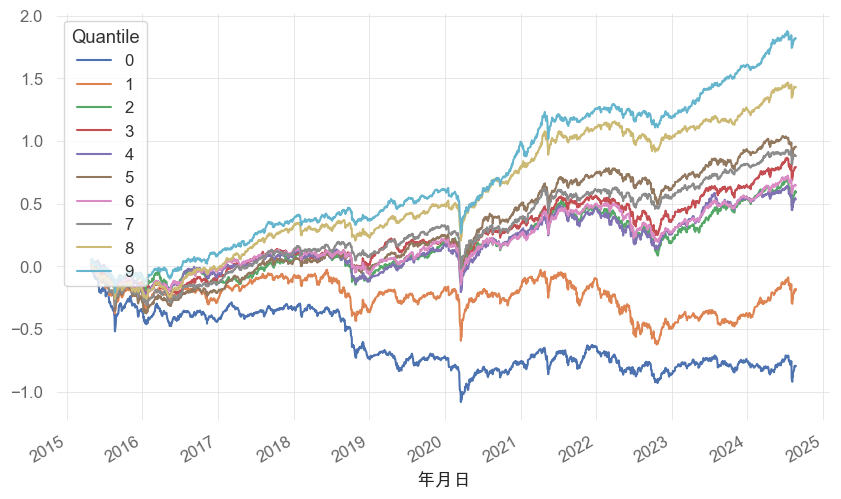

In [236]:
# All sample result
(portfolio).cumsum().plot()

<Axes: xlabel='年月日'>

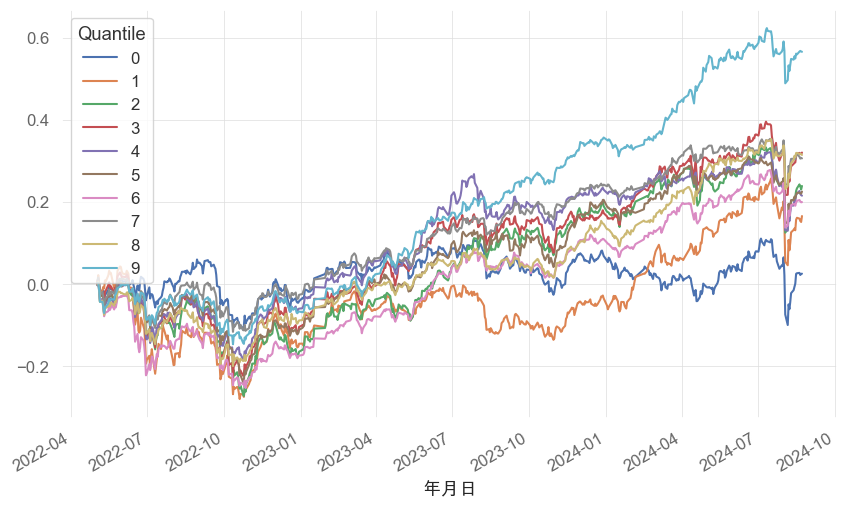

In [237]:
# Out of Sample Result
(portfolio['2022-5-1':]).cumsum().plot()

<Axes: xlabel='年月日'>

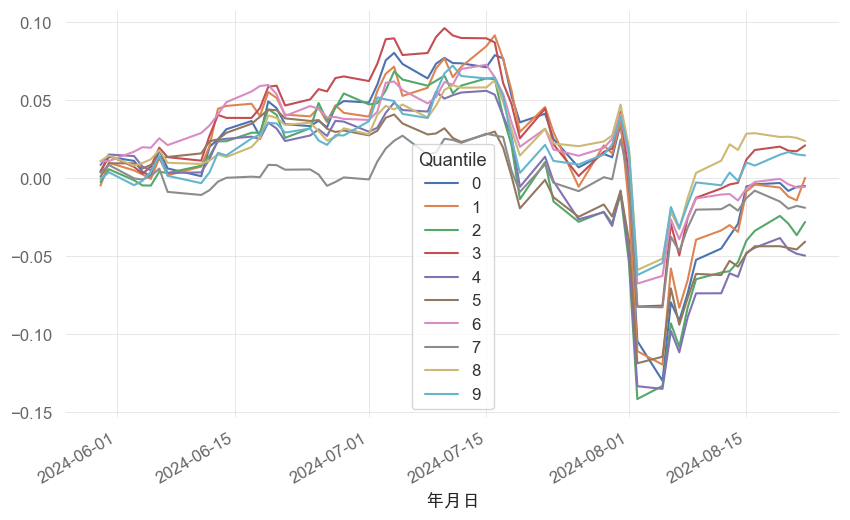

In [238]:
(portfolio['2024-5-30':]).cumsum().plot()

In [239]:
show_position_at_given_time(position, quantile = 9, date = '2024-05-30', save = True)

證券代碼
2867 三商壽      0.032258
2609 陽明       0.032258
5876 上海商銀     0.032258
4958 臻鼎-KY    0.032258
2888 新光金      0.032258
2809 京城銀      0.032258
9904 寶成       0.032258
2615 萬海       0.032258
2801 彰銀       0.032258
5469 瀚宇博      0.032258
2492 華新科      0.032258
2392 正崴       0.032258
2362 藍天       0.032258
2890 永豐金      0.032258
2357 華碩       0.032258
2201 裕隆       0.032258
2885 元大金      0.032258
2891 中信金      0.032258
2851 中再保      0.032258
2887 台新金      0.032258
2474 可成       0.032258
2880 華南金      0.032258
2892 第一金      0.032258
5880 合庫金      0.032258
2882 國泰金      0.032258
2915 潤泰全      0.032258
3010 華立       0.032258
2603 長榮       0.032258
2393 億光       0.032258
2881 富邦金      0.032258
6278 台表科      0.032258
Name: 9, dtype: float64

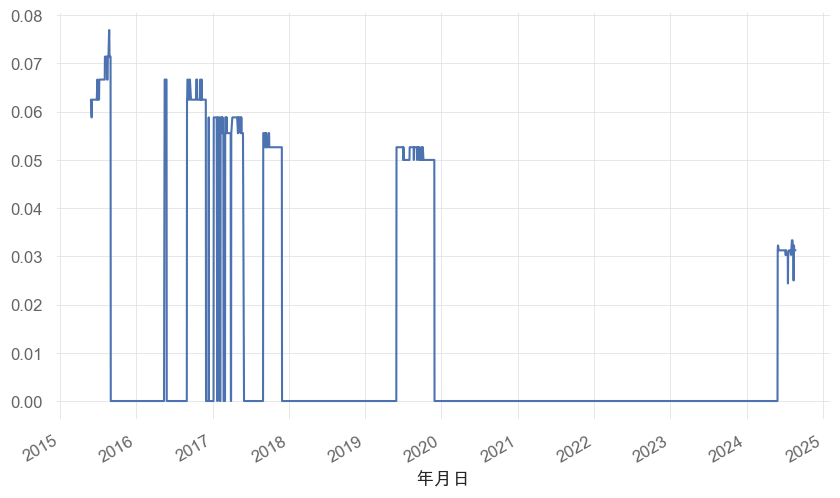

In [241]:
pos = show_position_for_given_stock(position, quantile=9, stock = '2888 新光金')
#print(pos.loc['2023-1-1':])

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


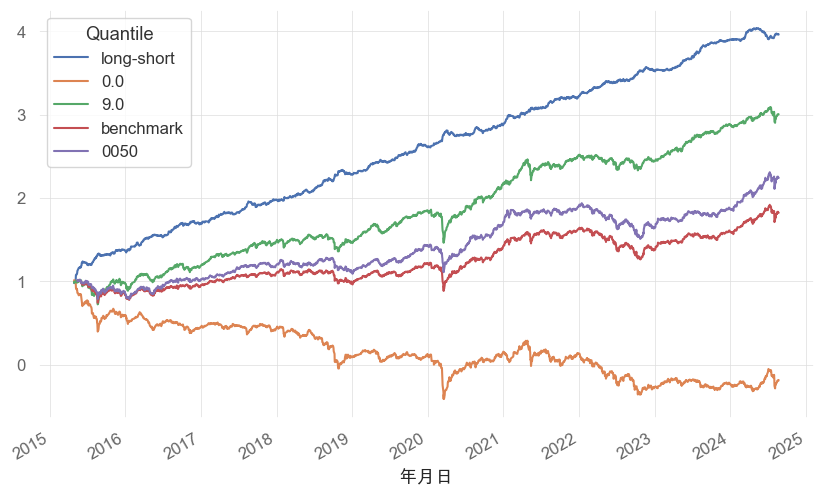

In [128]:
'''
交易成本估算：
    買進： 0.1425%
    賣出： 0.1425%
    證交稅： 0.3%
    每檔進出： 0.585%
    每季共 20*3 = 60 個交易日，平均每日交易成本 約 0.01%
'''
plot_portfolio(portfolio, tc = 0.0001, compounded = False)

In [129]:
metrics = qs.reports.metrics(portfolio, mode = 'Full', compounded=True)
#[[0, 9, 'long-short', '0050', 'benchmark']]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a s

                           0.0         1.0         2.0         3.0         4.0         5.0         6.0         7.0         8.0         9.0         long-short    benchmark    0050        reverse
-------------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ------------  -----------  ----------  ----------
Start Period               2015-05-15  2015-05-15  2015-05-15  2015-05-15  2015-05-15  2015-05-15  2015-05-15  2015-05-15  2015-05-15  2015-05-15  2015-05-15    2015-05-15   2015-05-15  2015-05-15
End Period                 2024-08-22  2024-08-22  2024-08-22  2024-08-22  2024-08-22  2024-08-22  2024-08-22  2024-08-22  2024-08-22  2024-08-22  2024-08-22    2024-08-22   2024-08-22  2024-08-22
Risk-Free Rate             0.0%        0.0%        0.0%        0.0%        0.0%        0.0%        0.0%        0.0%        0.0%        0.0%        0.0%          0.0%         0.0%        0.0%
Time in Market          

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a s

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2015-05-15   2015-05-15
End Period                 2024-08-22   2024-08-22
Risk-Free Rate             0.0%         0.0%
Time in Market             96.0%        100.0%

Cumulative Return          197.75%      563.19%
CAGR﹪                     8.46%        15.11%

Sharpe                     0.77         1.45
Prob. Sharpe Ratio         98.85%       100.0%
Smart Sharpe               0.74         1.4
Sortino                    1.1          1.91
Smart Sortino              1.05         1.84
Sortino/√2                 0.77         1.35
Smart Sortino/√2           0.75         1.3
Omega                      1.31         1.31

Max Drawdown               -36.04%      -30.5%
Longest DD Days            774          421
Volatility (ann.)          17.95%       15.32%
R^2                        0.47         0.47
Information Ratio          0.04         0.04
Calmar               

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-01-20,2020-03-18,2020-07-02,165,-30.499816,-26.610849
2,2015-05-29,2015-08-21,2016-02-25,273,-19.644794,-17.150271
3,2021-04-28,2021-05-14,2021-07-06,70,-19.373622,-14.537021
4,2022-01-05,2022-10-12,2023-03-01,421,-14.621354,-13.524430
5,2018-08-31,2018-10-25,2019-02-18,172,-13.467217,-13.317495


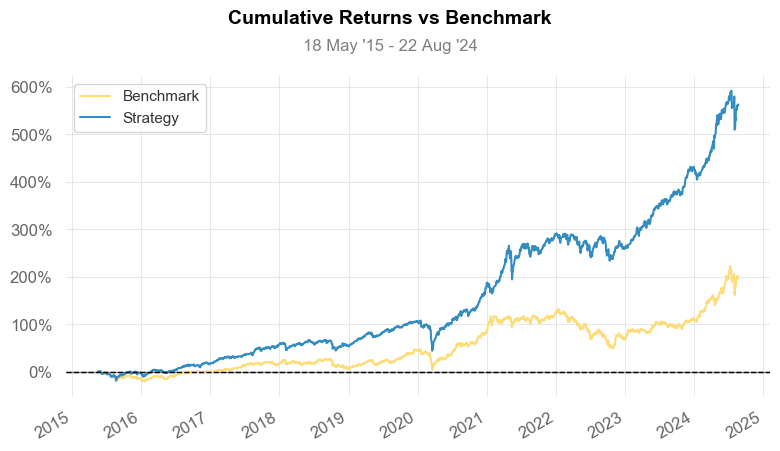

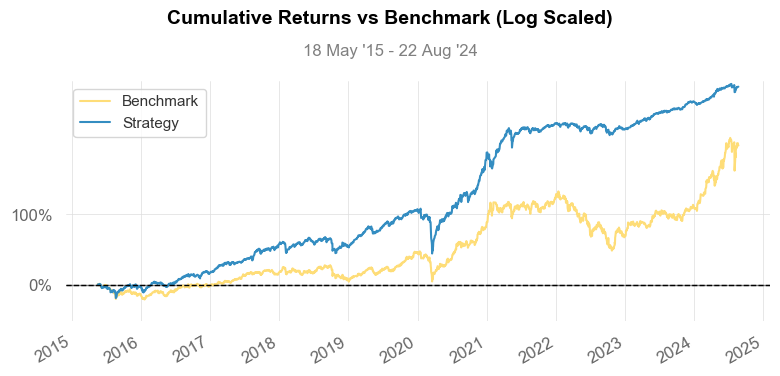

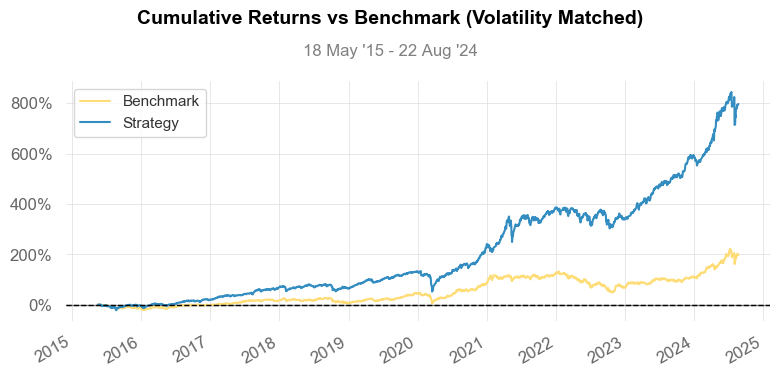

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/wrappers.py:555: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("A")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/wrappers.py:557: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("A")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/wrappers.py:565: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").apply(_stats.comp)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/wrappers.py:568: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").last()


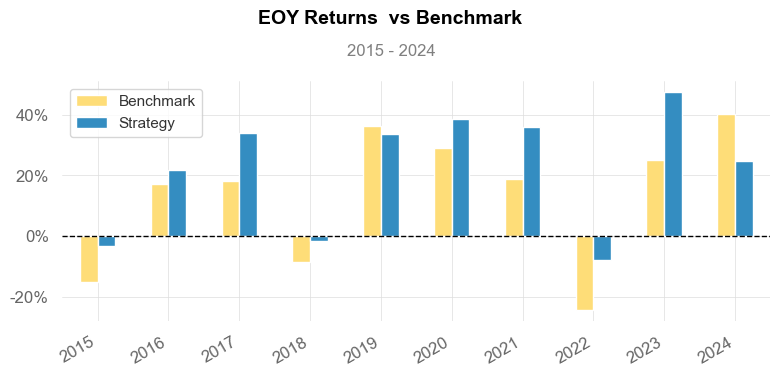

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/core.py:433: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/core.py:435: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/core.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns.fillna(0).resample(resample).apply(apply_fnc).resample(resample).last()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

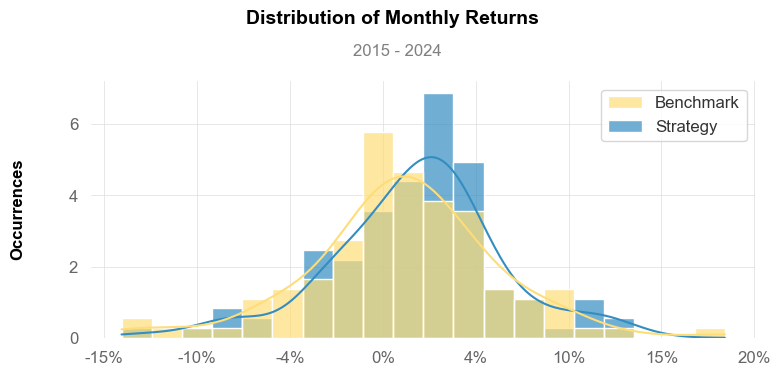

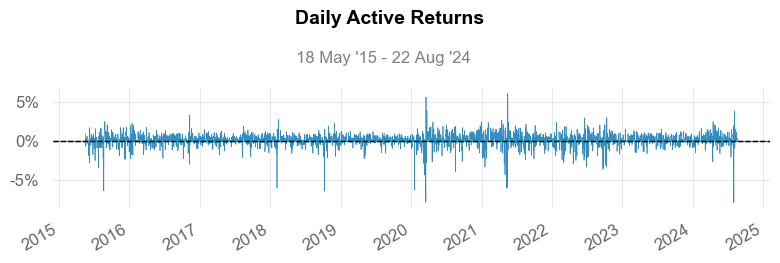

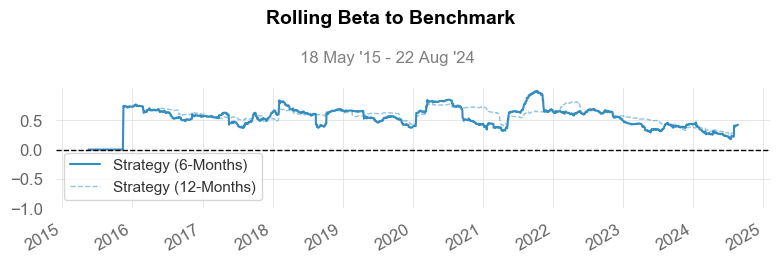

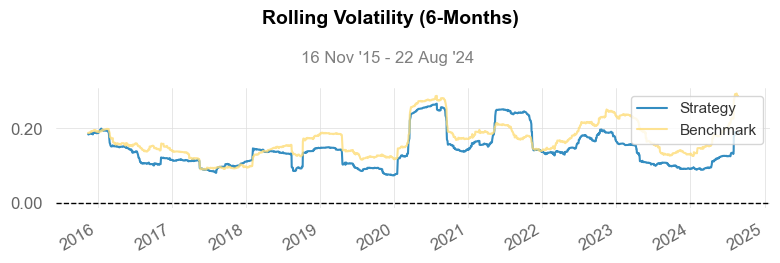

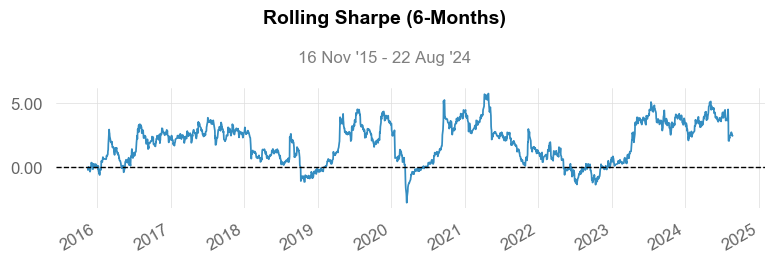

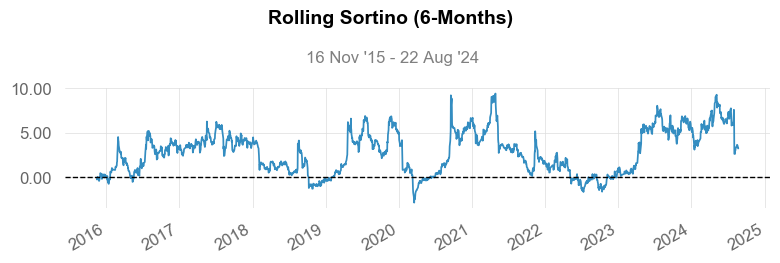

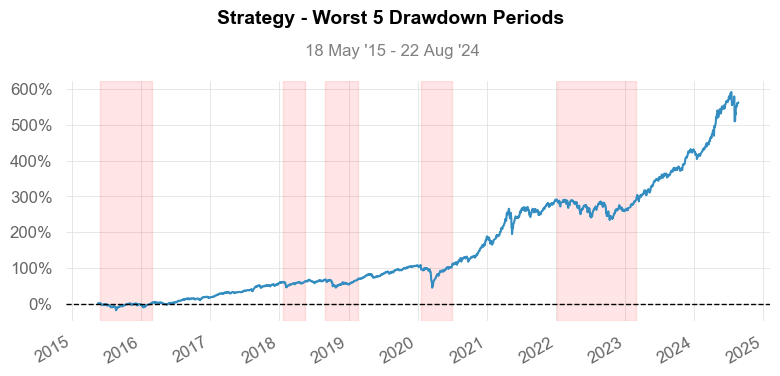

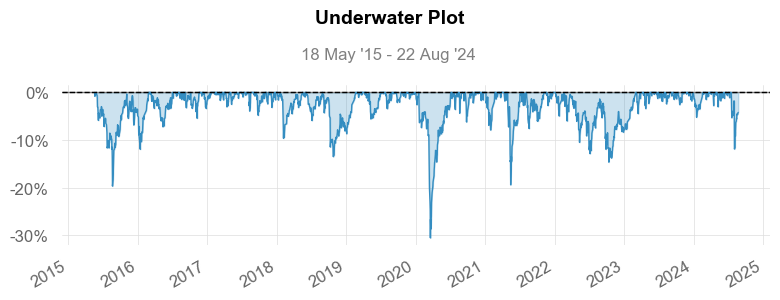

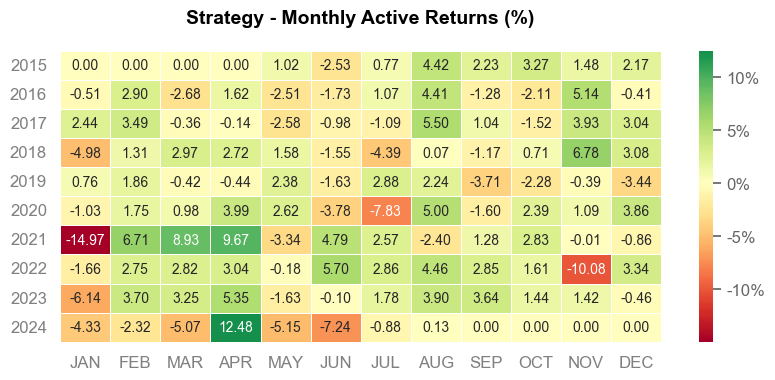

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/core.py:1016: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  port["Weekly"].ffill(inplace=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/_plotting/core.py:1018: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  port["Monthly"] = port["Daily"].resample("M").apply(apply_fnc)
/Library/Frameworks/Python.framework/Versions/3.10/lib/py

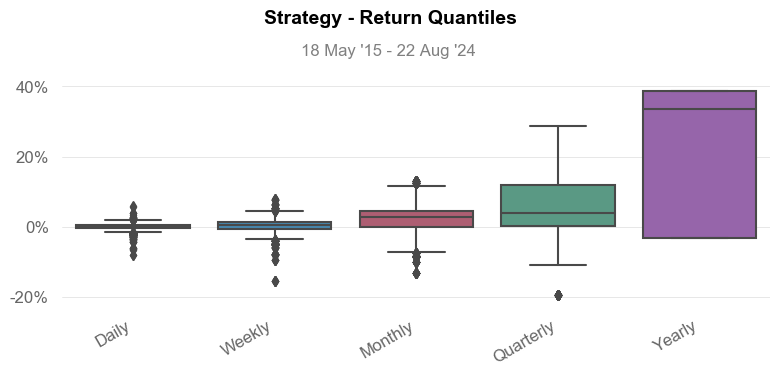

In [109]:
qs.reports.full(portfolio.loc[:, 14], benchmark=portfolio['0050'], active_returns = True)

In [113]:
import statsmodels.api as sm

df = portfolio.dropna(how='any')

X = sm.add_constant(df['0050'])
y = df[14]

result = sm.OLS(y, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   14.0   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     1995.
Date:                Thu, 29 Aug 2024   Prob (F-statistic):          1.01e-312
Time:                        11:24:50   Log-Likelihood:                 7983.9
No. Observations:                2257   AIC:                        -1.596e+04
Df Residuals:                    2255   BIC:                        -1.595e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      3.722      0.0

In [33]:
qs.reports.html(portfolio.loc[:, 9], benchmark=portfolio['0050'], active_returns = False)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a s

In [177]:
qs.reports.html(portfolio['long-short'], benchmark=portfolio['0050'], active_returns = False)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/quantstats/utils.py:269: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To 